# PrivacyNet on MNIST data.

In [1]:
import numpy as np
from keras.datasets import mnist
import random

Using TensorFlow backend.


In [2]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 8
plt.rcParams['figure.figsize'] = (8,8)

In [3]:
from sklearn import preprocessing
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.convolutional import UpSampling2D
from keras.layers import Conv2D, MaxPooling2D,LeakyReLU,Conv2DTranspose
from keras.layers import Input, Lambda, concatenate, Add, Concatenate
from keras import backend as K

from keras.optimizers import Adam, RMSprop

In [4]:
from privacy_net.utils.module import u_tail
from privacy_net.utils.module import y_tail
from privacy_net.utils.module import InstanceNormalization2D
from privacy_net.utils.module import residual_block
from privacy_net.models.privacy_net_model import privacyNet

/home/mx/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
def generator(img):
    #     def tileAttr(x):
    #         x = tf.expand_dims(x, axis = 1)
    #         x = tf.expand_dims(x, axis = 2)
    #         return tf.tile(x, [1, size, size, 1])

    #     y = Concatenate()([img, Lambda(tileAttr)(attr)])

    y = Conv2D(32, 5, padding="same", kernel_initializer='he_normal')(img)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2D(64, 3, strides=2, padding="same", kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2D(128, 3, strides=2, padding="same", kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = residual_block(y, 128, 3)
    y = residual_block(y, 128, 3)
    y = residual_block(y, 128, 3)
    y = residual_block(y, 128, 3)

    y = Conv2DTranspose(64, 3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2DTranspose(32, 3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2D(1, 5, strides=1, padding='same', kernel_initializer='he_normal')(y)
    y = Activation('tanh')(y)
    return y

In [6]:
def discriminator(img, u_size, y_size, u_feat_dims=None, y_feat_dims=None, activation='tanh'):

    y = Conv2D(32, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(img)
    y = LeakyReLU(alpha=0.2)(y)  # 14 14 32
    y = Dropout(0.25)(y)

    y = Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = ZeroPadding2D(padding=((0, 1), (0, 1)))(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 8 8 64
    y = Dropout(0.25)(y)

    y = Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 4 4 128
    y = Dropout(0.25)(y)

    y = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 4 4 256
    y = Dropout(0.25)(y)

    y = Conv2D(512, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 2 2 512
    y = Dropout(0.25)(y)

    pred_f_u = []
    if not u_feat_dims:
        u_feat_dims = [2 for _ in range(u_size)]
        
    pred_f_y = []
    if not y_feat_dims:
        y_feat_dims = [2 for _ in range(y_size)]

    for i in range(u_size):
        temp_u = Conv2D(u_feat_dims[i], kernel_size=2, strides=1, kernel_initializer='he_normal',
                        activation=activation)(y)
        temp_u = Flatten()(temp_u)
        pred_f_u.append(temp_u)
        
    for i in range(y_size):
        temp_y = Conv2D(y_feat_dims[i], kernel_size=2, strides=1, kernel_initializer='he_normal',
                        activation=activation)(y)
        temp_y = Flatten()(temp_y)
        pred_f_y.append(temp_y)

    return pred_f_u,pred_f_y

In [7]:
def generatorV2(img):

    
    trans_x = Conv2D(32, kernel_size=3,
                         padding='same',
                         activation='relu')(img)
    trans_x = Conv2D(64, kernel_size=3,
                         padding='same',
                         activation='relu')(trans_x)
    trans_x = Conv2D(1, 5, strides=1, padding='same', kernel_initializer='he_normal')(trans_x)
    trans_x = Activation('tanh')(trans_x)
    return trans_x

In [8]:
def generatorV3(img):
    def mean_layer(x):
        x = tf.reduce_mean(x, axis=3)
        return tf.expand_dims(x, -1)
    trans_x = Conv2D(32, kernel_size=3,
                         padding='same',
                         activation='relu')(img)
    trans_x = Conv2D(64, kernel_size=3,
                         padding='same',
                         activation='tanh')(trans_x)
    trans_x = Lambda(mean_layer)(trans_x)
    return trans_x

In [9]:
def generatorV4(img):
    def mean_layer(x):
        x = tf.reduce_mean(x, axis=3)
        return tf.expand_dims(x, -1)
    trans_x = Conv2D(96, kernel_size=3,
                         padding='same',
                         activation='tanh')(img)
    trans_x = Lambda(mean_layer)(trans_x)
    return trans_x

In [10]:
def save_some(im_list,name):
    im_list = np.squeeze(im_list)
    num_list = len(im_list)
    plt.figure(figsize=(3 * num_list, 4))
    for i, array in enumerate(im_list):
        plt.subplot(1, len(im_list), i + 1)
        plt.imshow(((array + 1) * 127.5).astype(np.uint8), cmap='gray')
        plt.axis('off')
    plt.savefig(name)

# data generator even-five experiment

In [11]:
# generate images and labels for EVEN-FIVE experiment
class mnistGenerator():
    def __init__(self, batch_size=16):

        self.input_shape = (28, 28, 1)
        self.batch_size = batch_size
        (self.x_train, self.digit_train), (self.x_test, self.digit_test) = mnist.load_data()
        self.x_train = np.expand_dims(self.x_train, axis=-1)
        self.x_test = np.expand_dims(self.x_test, axis=-1)

        self.u_train, self.u_test = self.load_public_label()
        self.y_train, self.y_test = self.load_sensitive_label()
        self.train_size = self.x_train.shape[0]
        self.test_size = self.x_test.shape[0]
        self.steps_per_epoch = self.default_training_steps
        self.test_steps = self.default_testing_steps

        self.cur_train_step = 0
        self.cur_test_step = 0
        self.train_ind_list = np.array([i for i in range(self.train_size)])
        self.test_ind_list = np.array([i for i in range(self.test_size)])

    # property is a getter
    @property
    def default_training_steps(self):
        # make sure train with full batch size which means each epoch less than batch size images being used.
        return int(np.floor(self.train_size / self.batch_size))

    @property
    def default_testing_steps(self):
        # make sure train with full batch size which means each epoch less than batch size images being used.
        return int(np.floor(self.test_size / self.batch_size))

    def load_public_label(self):
        # prepare utility labels
        u_train = np.zeros_like(self.digit_train)
        u_test = np.zeros_like(self.digit_test)

        u_train[self.digit_train % 2 == 1] = 1
        u_test[self.digit_test % 2 == 1] = 1

        return u_train, u_test

    def load_sensitive_label(self):
        # prepare privacy labels
        y_train = np.zeros_like(self.digit_train)
        y_test = np.zeros_like(self.digit_test)

        y_train[self.digit_train >= 5] = 1
        y_test[self.digit_test >= 5] = 1
        return y_train, y_test

    def nextTrain(self):
        while True:

            # set self.cur_train_ind
            # cur_train_ind has indices of batch_sizes, this indices correpond to the image ids
            self.fetchCurrentTrainInd()
            train_x = self.x_train[self.cur_train_ind]
            train_x = train_x / 127.5 - 1

            train_u = np.zeros((self.batch_size, 2))
            for i in range(self.batch_size):
                train_u[i][self.u_train[self.cur_train_ind[i]]] = 1
            train_y = np.ones((self.batch_size, 2))
            for i in range(self.batch_size):
                train_y[i][self.y_train[self.cur_train_ind[i]]] = 0

            inputs = {'input_x': train_x, 'input_y': [train_y], 'input_u': [train_u]}
            output = np.zeros((self.batch_size, 1))
            self.cur_train_step += 1
            yield inputs, output

    def fetchCurrentTrainInd(self):
        # this function find cur_train_ind for each step
        # it read batch_size's image_ids, starting from cur_train_step(batch_size,augment_ratio)

        # if self.cur_train_step%self.augment_ratio != 0:
        #     return
        random.seed(1234)

        # when epoch end it will shuffle image_ids and reset cur_train_step, namely, read from the start
        if self.cur_train_step >= self.steps_per_epoch:
            random.shuffle(self.train_ind_list)
            # print("shuffling")
            self.cur_train_step = 0

        cur_train_start = int(self.cur_train_step) * self.batch_size
        cur_train_end = cur_train_start + self.batch_size
        if cur_train_end > self.train_size:
            cur_train_end = self.train_size
        self.cur_train_ind = self.train_ind_list[np.arange(cur_train_start, cur_train_end).astype(int)]

    def nextVal(self):
        while True:
            if self.cur_test_step == self.test_steps:
                self.cur_test_step = 0
            cur_test_start = int(self.cur_test_step) * self.batch_size
            cur_test_end = cur_test_start + self.batch_size
            if cur_test_end > self.test_size:
                cur_test_end = self.test_size
            self.cur_test_ind = self.test_ind_list[np.arange(cur_test_start, cur_test_end)]

            test_x = self.x_test[self.cur_test_ind]
            test_x = test_x / 127.5 - 1

            test_u = np.zeros((self.batch_size, 2))
            for i in range(self.batch_size):
                test_u[i][self.u_test[self.cur_test_ind[i]]] = 1
            test_y = np.ones((self.batch_size, 2))
            for i in range(self.batch_size):
                test_y[i][self.y_test[self.cur_test_ind[i]]] = 0

            self.cur_test_step += 1
            inputs = {'input_x': test_x, 'input_y': [test_y], 'input_u': [test_u]}
            output = np.zeros((self.batch_size, 1))
            yield inputs, output

In [12]:
mnist_g = mnistGenerator()

In [13]:
def plot_some(im_list):
    im_list = np.squeeze(im_list)
    num_list = len(im_list)
    plt.figure(figsize=(3 * num_list, 4))
    for i, array in enumerate(im_list):
        plt.subplot(1, len(im_list), i + 1)
        plt.imshow(((array + 1) * 127.5).astype(np.uint8), cmap='gray')
        plt.axis('off')
    plt.show()

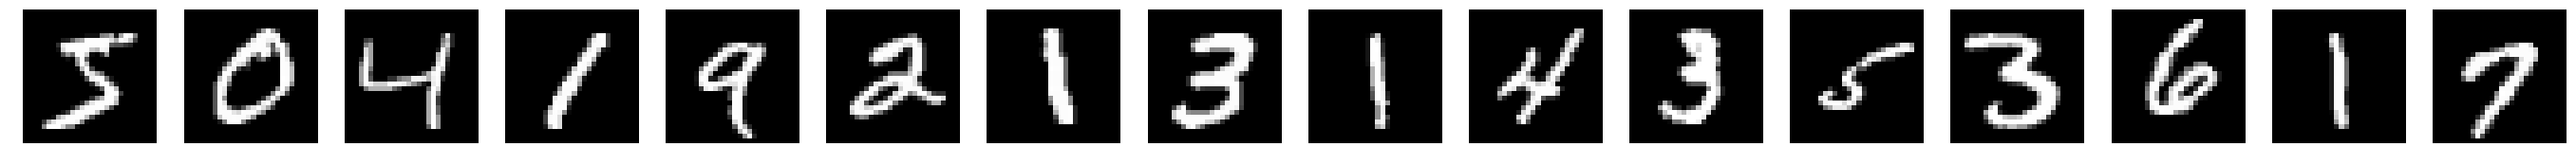

In [14]:
inputs,_ = next(mnist_g.nextTrai())
input_x = inputs['input_x']
plot_some(np.squeeze(input_x))

In [16]:
input_u = inputs['input_u']
print(input_u)

[array([[ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.]])]


In [12]:
class privacyNetV3(privacyNet):

    def __init__(self, u_input_dims=[2, 2, 2, 2], y_input_dims=[2], u_feat_dims=[2, 2, 2, 2],
                 y_feat_dims=[2], mode=0,
                 **kwargs):
        self.u_input_dims = u_input_dims
        self.y_input_dims = y_input_dims
        self.u_feat_dims = u_feat_dims
        self.y_feat_dims = y_feat_dims
        self.mode = mode  # 0->generatorV2 1->generatorV3 2->generatorV4
        super(privacyNetV3, self).__init__(**kwargs)

    def build_model(self):

        """Build Discriminator and Generator and Transformer, seperately.
        This method requires no inputs and returns nothing.
        self.d_model, self.g_model, self.transform_tail_models are goals for this method.
        NOTE: The following 'Output's and 'Input's are used for introducing model specs.

        # D model arguments:
            - d_model: Discriminator part.
        Input:
            - attr_y_input: list of Input Tensors. sensitive labels, Y.
            - attr_u_input(Optional): list, of Input Tensors. public labels, U.
            - img_input: Input Tensor, shared with g_model. raw images, X.
        Output:
            - loss_y_output: list, H-score between imgs and sensitive labels. H_score.
            - loss_u_output: list, H-score between imgs and public labels. Might be None. H_score
            - pred_real: predictions of real images. prob.
            - pred_f_y: list, feature of Y. y(X).
            - pred_f_u: list, feature of U. u(X).

        # G model:
            - g_model: Generator part.
        Input:
            - img_input: Input Tensor, shared with d_model. raw images, X.
        Output:
            - img_output: transformed images. transformed images, Z.

        # T models:
            - transform_tail_models: list of T models.
        Input:
            - transform_y_input: list of input of third networks in order to filter
                                 sensitive information. y(Z)
        Output:
            - transform_y_tail: list. h(y(Z))

        """
        ################## Part I ######################
        ## start building D model
        self.img_input = Input(self.image_size)
        self.attr_y_input = []  # placeholder for every sensitive labels
        self.attr_u_input = []  # placeholder for every public labels

        for i in range(self.y_size):
            self.attr_y_input.append(Input((self.y_input_dims[i],)))
        for j in range(self.u_size):
            self.attr_u_input.append(Input((self.u_input_dims[j],)))

        self.pred_real, self.pred_f_u, self.pred_f_y = discriminator(self.img_input,
                                                                     self.u_size,
                                                                     self.y_size,
                                                                     self.u_feat_dims,
                                                                     self.y_feat_dims,
                                                                     activation=self.activation)

        # All tail networks are separated
        self.attr_y_tail = []  # holding tails network for sensitive_attrs
        self.attr_u_tail = []  # holding tails network for public_attrs

        for i in range(self.y_size):
            self.attr_y_tail.append(y_tail(self.attr_y_input[i],
                                           self.y_feat_dims[i],
                                           activation=self.activation))

        for j in range(self.u_size):
            self.attr_u_tail.append(u_tail(self.attr_u_input[j],
                                           self.u_feat_dims[j],
                                           activation=self.activation))

        self.loss_y_output = []  # containing sensitive H-score
        self.loss_u_output = []  # containing public H-score

        for i in range(self.y_size):
            self.loss_y_output.append(Lambda(self.neg_hscore)([self.pred_f_y[i], self.attr_y_tail[i]]))

        for j in range(self.u_size):
            self.loss_u_output.append(Lambda(self.neg_hscore)([self.pred_f_u[j], self.attr_u_tail[j]]))

        self.d_model = Model(inputs=[self.img_input] + self.attr_u_input + self.attr_y_input,
                             outputs=[self.pred_real] + self.loss_u_output + self.loss_y_output
                                     + self.pred_f_u + self.pred_f_y + self.attr_u_tail + self.attr_y_tail)
        if self.d_model_dir:
            self.d_model.load_weights(self.d_model_dir)  # load pretrained model if avialable
        ## end building D model

        ################## Part II ######################
        ## start building G model
        if self.mode == 0:
            self.img_output = generatorV2(self.img_input)  # pass image into generator
        elif self.mode == 1:
            self.img_output = generatorV3(self.img_input)  # pass image into generator
        elif self.mode == 2:
            self.img_output = generatorV4(self.img_input)  # pass image into generator
        else:
            self.img_output = generator(self.img_input)  # pass image into generator

        self.g_model = Model(inputs=[self.img_input], outputs=[self.img_output])

        if self.g_model_dir:
            self.g_model.load_weights(self.g_model_dir)  # load pretrained model if avialable
        ## end building G model

        ################## Part III ######################
        ## start building T model
        self.transform_y_input = []  # T model inputs
        for i in range(self.y_size):
            self.transform_y_input.append(Input((self.y_feat_dims[i],)))

        self.transform_y_tail = []  # T model outputs
        for i in range(self.y_size):
            self.transform_y_tail.append(y_tail(self.transform_y_input[i],
                                                self.y_feat_dims[i],
                                                activation=self.activation))
        self.transform_tail_models = []
        for i in range(self.y_size):
            self.transform_tail_models.append(Model(inputs=[self.transform_y_input[i]],
                                                    outputs=[self.transform_y_tail[i]]))
        if self.t_model_y_dir:
            for ind_y in range(self.y_size):
                self.transform_tail_models[ind_y].load_weights(self.t_model_y_dir[ind_y])
        ## end building T model

    def build_loss(self):
        """Build Discriminator and Generator and Transformer loss, itegrating G,D,T into privacy_net model.
        This project uses three steps training, D->T->G. Thus, three losses are introduced accordingly.

        # Network Arguments:

            - img_a: Input Tensor. Raw images.
            - attr_y: list, Input Tensors. Sensitive labels.
            - attr_u: list, Input Tensors. Public labels.
            - img_a_trans: Output Tensor of G. Transformed images.
            - pred_real(local): List, Output tensor of D. On raw images.
            Details: pred_real
            |0       |1:1+u_size   |1+u_size:1+u_size+y_size|1+u_size+y_size:1+u_size*2+y_size|1+u_size*2+y_size:1+u_size*2+y_size*2|
            1+u_size*2+y_size*2:1+u_size*3+y_size*2|1+u_size*3+y_size*2:1+u_size*3+y_size*3|
            |pred_dis|loss_u_hscore|      loss_y_hscore     |           u(X)                  |               y(X)                  |
                               f(U)                |                   g(Y)                |
            - pred_trans(local): List, Output tensor of D. On transformed images.
            Details: pred_trans
            |0       |1:1+u_size   |1+u_size:1+u_size+y_size|1+u_size+y_size:1+u_size*2+y_size|1+u_size*2+y_size:1+u_size*2+y_size*2|
            1+u_size*2+y_size*2:1+u_size*3+y_size*2|1+u_size*3+y_size*2:1+u_size*3+y_size*3|
            |pred_dis|loss_u_hscore|      loss_y_hscore     |           u(Z)                  |               y(Z)                  |
                               f(U)                |                   g(Y)                |
            - h_z(local): list, Output Tensors of T. h(y(Z)).

        D loss Arguments:

        G loss Arguments:

        T loss Arguments:

        Print Arguments:

        """

        # Same implementation with neg_hscore, in case of mixing up with Lambda layer.
        def neg_hscore_loss(x):
            """
            neg hscore loss implementation
            """
            f = x[0]
            g = x[1]
            f0 = f - K.mean(f, axis=0)
            g0 = g - K.mean(g, axis=0)
            corr = tf.reduce_mean(tf.reduce_sum(tf.multiply(f0, g0), 1))
            cov_f = K.dot(K.transpose(f0), f0) / K.cast(K.shape(f0)[0] - 1, dtype='float32')
            cov_g = K.dot(K.transpose(g0), g0) / K.cast(K.shape(g0)[0] - 1, dtype='float32')
            return - corr + tf.trace(K.dot(cov_f, cov_g)) / 2

        ########### Part 0 ################
        ## Connecting three models
        self.img_a = Input(shape=self.image_size)  # Raw images tensor.

        self.attr_y = []  # sensitive_label tensor.
        self.attr_u = []  # public_label tensor.
        for i in range(self.y_size):
            self.attr_y.append(Input((self.y_input_dims[i],)))
        for j in range(self.u_size):
            self.attr_u.append(Input((self.u_input_dims[j],)))

        self.img_a_trans = self.g_model(self.img_a)  # Transformed image Tensor.
        pred_real = self.d_model([self.img_a] + self.attr_u + self.attr_y)  # D output tensor.
        pred_trans = self.d_model([self.img_a_trans] + self.attr_u + self.attr_y)  # D output tensor.

        h_z = []  # h(y(Z)) tensor.
        for i in range(self.y_size):
            h_z.append(self.transform_tail_models[i](pred_trans[1 + self.u_size * 2 + self.y_size + i]))
        ## end Connecting three models

        ############## Part I #################
        ## build D loss
        # discriminate real or fake, follows WGAN.
        d_loss_real = K.mean(K.square(K.ones_like(pred_real[0]) - pred_real[0]), axis=-1)
        d_loss_fake = K.mean(K.square(K.zeros_like(pred_trans[0]) - pred_trans[0]), axis=-1)

        # gradient panelty: WGAN-gp
        self.eps_input = K.placeholder(shape=(None, 1, 1, 1))
        mixed_input = Input(shape=self.image_size,
                            tensor=self.eps_input * self.img_a + (1 - self.eps_input) * self.img_a_trans)
        gp_pred = self.d_model([mixed_input] + self.attr_u + self.attr_y)
        grad_mixed = K.gradients(gp_pred[0], [mixed_input])[0]
        norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1, 2, 3]))
        d_loss_gp = K.mean(K.square(norm_grad_mixed - 1))

        # compute u_loss in total
        for i in range(1, 1 + self.u_size):
            if i == 1:
                d_loss_u_total = pred_real[i]
            else:
                d_loss_u_total += pred_real[i]

        # compute y_loss in total
        for j in range(1 + self.u_size, 1 + self.u_size + self.y_size):
            if j == 1 + self.u_size:
                d_loss_y_total = pred_real[j]
            else:
                d_loss_y_total += pred_real[j]

        # d_loss = u_loss+y_loss+loss_real+loss_fake+loss_gp
        if self.u_size == 0:
            self.d_loss = d_loss_real + d_loss_fake + self.lambda_cls * ((
                                                                                 1. / self.y_size) * d_loss_y_total) + self.lambda_gp * d_loss_gp
        else:
            self.d_loss = d_loss_real + d_loss_fake + self.lambda_cls * ((1 / self.u_size) * d_loss_u_total + (
                    1. / self.y_size) * d_loss_y_total) + self.lambda_gp * d_loss_gp
        ## end build D loss

        ############## Part II #################
        ## build G
        # loss real
        g_loss_fake = K.mean(K.square(K.ones_like(pred_trans[0]) - pred_trans[0]), axis=-1)

        # loss_u is Hscore(u(X),u(Z))
        for i_g in range(1 + self.u_size + self.y_size, 1 + self.u_size * 2 + self.y_size):
            if i_g == 1 + self.u_size + self.y_size:
                g_loss_u_total = neg_hscore_loss([pred_trans[i_g], pred_real[i_g]])
            else:
                g_loss_u_total += neg_hscore_loss([pred_trans[i_g], pred_real[i_g]])

        # loss_u is Hscore(y(X),h(y(Z)))
        for j_g in range(1 + self.u_size * 2 + self.y_size, 1 + self.u_size * 2 + self.y_size * 2):
            if j_g == 1 + self.u_size * 2 + self.y_size:
                g_loss_y_total = neg_hscore_loss([h_z[j_g - (1 + self.u_size * 2 + self.y_size)], pred_real[j_g]])
            else:
                g_loss_y_total += neg_hscore_loss([h_z[j_g - (1 + self.u_size * 2 + self.y_size)], pred_real[j_g]])

        if self.u_size == 0:
            self.g_loss = g_loss_fake - self.lambda_cls * ((
                                                                   1. / self.y_size) * self.gamma * g_loss_y_total)
        else:
            self.g_loss = g_loss_fake + self.lambda_cls * ((1. / self.u_size) * g_loss_u_total - (
                    1. / self.y_size) * self.gamma * g_loss_y_total)
        ## end build G loss

        ############## Part III ###############
        ## build T loss
        self.transform_loss = []  # list, transform loss.

        # H-score of Hscore[h(y(Z)),y(X)]
        for i in range(self.y_size):
            self.transform_loss.append(neg_hscore_loss([h_z[i], pred_real[1 + self.u_size * 2 + self.y_size + i]]))
        ## end build T loss

        # save list for detail printing.
        self.d_loss_list_print = []
        self.d_loss_list_print.append(d_loss_real)
        self.d_loss_list_print.append(d_loss_fake)
        if self.u_size > 0:
            self.d_loss_list_print.append(d_loss_u_total)
        self.d_loss_list_print.append(d_loss_y_total)
        self.d_loss_list_print.append(d_loss_gp)

        self.g_loss_list_print = []
        self.g_loss_list_print.append(g_loss_fake)
        if self.u_size > 0:
            self.g_loss_list_print.append(g_loss_u_total)
        self.g_loss_list_print.append(g_loss_y_total)

    def build_optimizer(self):

        self.g_training_updates = Adam(lr=self.lr, decay=5e-9, beta_1=self.b1, beta_2=self.b2).get_updates(
            self.g_model.trainable_weights, [], self.g_loss)
        self.g_train = K.function([self.img_a] + self.attr_u + self.attr_y, self.g_loss_list_print,
                                  self.g_training_updates)

        self.transform_train = []
        for i in range(self.y_size):
            self.transform_training_updates = Adam(lr=self.lr, decay=5e-9, beta_1=self.b1, beta_2=self.b2).get_updates(
                self.transform_tail_models[i].trainable_weights, [], self.transform_loss[i])
            self.transform_train.append(K.function([self.img_a] + self.attr_u + self.attr_y,
                                                   [self.transform_loss[i]], self.transform_training_updates))

        self.d_training_updates = Adam(lr=self.lr, decay=5e-9, beta_1=self.b1, beta_2=self.b2).get_updates(
            self.d_model.trainable_weights, [], self.d_loss)
        self.d_train = K.function([self.img_a, self.eps_input] + self.attr_u + self.attr_y, self.d_loss_list_print,
                                  self.d_training_updates)

    def hscore_accu(self, pred, pred_dummy, pu, py, u_labels, y_labels):
        """
        For testing images only. This function compute the accuracy of each private/public attributes.
        Note: At early stage, the evaluation model is still under training. One can simply look at the accuracy curve
        of each attribute(on original images) to determine whether the models are ready.
        One convenience is that we do not need to train auxiliary models to evaluate.
        Input:
            - pred: output of d_model
            - pred_dummy: to extract output of a-models(np.eye(2) as input).
            Details:
            |0       |1:1+u_size   |1+u_size:1+u_size+y_size|1+u_size+y_size:1+u_size*2+y_size|1+u_size*2+y_size:1+u_size*2+y_size*2|
            1+u_size*2+y_size*2:1+u_size*3+y_size*2|1+u_size*3+y_size*2:1+u_size*3+y_size*3|
            |pred_dis|loss_u_hscore|      loss_y_hscore     |           u(X)                  |               y(X)                  |
                               f(U)                |                   g(Y)                |
            - py: list, labels marginal distribution. (training data)
            - pu: list, labels marginal distribution. (training data)
            - y_labels: list, labels of private attrs
            - u_labels: list, models of public attrs
        Output:
            - d_score: 1 - Loss_real
            - u_accu: list, utility accuracy on each attrs. JUST LIKE LOG-LOSS!!!
            - p_accu: list, privacy accuracy on each attrs.
        """
        p_accu = []
        for ind_y in range(self.y_size):
            y_X = pred[1 + self.u_size * 2 + self.y_size + ind_y]  # temp vars to save y(X)
            y_X = y_X - np.mean(y_X, axis=0)  # centralized feature
            g_Y = pred_dummy[1 + self.u_size * 3 + self.y_size * 2 + ind_y]  # temp vars to save g(Y)
            g_Y = g_Y - np.mean(g_Y, axis=0)  # centralized feature

            py_X = py[ind_y] * (1 + np.matmul(y_X, g_Y.T))  # prob of each class
            p_accu.append(np.mean(np.argmax(py_X, axis=1) == np.argmax(y_labels[ind_y], axis=1)))  # calculate accu

        u_accu = []
        for ind_u in range(self.u_size):
            u_X = pred[1 + self.u_size + self.y_size + ind_u]
            u_X = u_X - np.mean(u_X, axis=0)

            f_U = pred_dummy[1 + self.u_size * 2 + self.y_size * 2 + ind_u]
            f_U = f_U - np.mean(f_U, axis=0)
            pu_X = pu[ind_u] * (1 + np.matmul(u_X, f_U.T))  # prob of each class
            u_accu.append(np.mean(np.argmax(pu_X, axis=1) == np.argmax(u_labels[ind_u], axis=1)))
        return 1 - np.mean(pred[0]), u_accu, p_accu

    def train(self):

        dict_val, _ = next(self.celeba_generator.nextVal())
        sample_input_x = dict_val['input_x']
        save_some(sample_input_x[:10], os.path.join(self.log_dir, 'original_image'))

        print("start training:")
        start_time = time.time()
        for j in range(self.start_epoch, self.num_epochs):
            # clean up loss logs on epoch begin, loss list different when u_size = 0
            if self.u_size > 0:
                loss_g = [[] for _ in range(4)]
                loss_d = [[] for _ in range(6)]
            else:
                loss_g = [[] for _ in range(3)]
                loss_d = [[] for _ in range(5)]
            loss_t = []
            for i in range(self.celeba_generator.steps_per_epoch):
                # start_1 = time.time()
                dict_input, _ = next(self.celeba_generator.nextTrain())
                input_x = dict_input['input_x']
                input_y = dict_input['input_y']
                input_u = dict_input['input_u']
                input_y_batch = []
                input_u_batch = []
                for ind_1 in range(self.y_size):
                    input_y_batch.append(input_y[ind_1])
                for ind_2 in range(self.u_size):
                    input_u_batch.append(input_u[ind_2])

                for _ in range(self.d_ites):
                    d_loss_list = self.d_train(
                        [input_x, np.random.uniform(0, 1, (self.batch_size, 1, 1, 1))] + input_u_batch + input_y_batch)

                errT = []
                for ind_t in range(self.y_size):
                    errT.append(self.transform_train[ind_t]([input_x] + input_u_batch + input_y_batch))

                for _ in range(self.g_ites):
                    g_loss_list = self.g_train([input_x] + input_u_batch + input_y_batch)

                if i % 100 == 0:
                    et = time.time() - start_time
                    et = str(datetime.timedelta(seconds=et))[:-7]
                    # trans_x = self.g_model.predict(input_x)
                    # input_u_dummy = [np.eye(2) for _ in range(self.u_size)]
                    # input_y_dummy = [np.eye(2) for _ in range(self.y_size)]
                    # pred_real = self.d_model.predict([input_x]+input_u_batch+input_y_batch)
                    # pred_trans = self.d_model.predict([trans_x]+input_u_batch+input_y_batch)
                    # pred_dummy = self.d_model.predict([input_x[:2]]+input_u_dummy+input_y_dummy)
                    # real_auth_score, real_uaccu, real_paccu = self.hscore_accu(pred_real,pred_dummy,[0.5 for _ in range(5)],[0.5],input_u_batch,input_y_batch)
                    # trans_auth_score, trans_uaccu, trans_paccu = self.hscore_accu(pred_trans,pred_dummy,[0.5 for _ in range(5)],[0.5],input_u_batch,input_y_batch)
                    if self.u_size > 0:
                        print(
                            'Elapsed [{}], epoch{}/{}, batch:{}/{},loss_real D:{},loss_fake D:{},loss_u D:{},loss_y D:{}, loss_gp D:{}, loss_t:{}'.
                            format(et, j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                                   np.mean(d_loss_list[0]), np.mean(d_loss_list[1]),
                                   np.mean(d_loss_list[2]), np.mean(d_loss_list[3]), np.mean(d_loss_list[4]),
                                   np.mean(errT)))
                        print('Elapsed [{}], epoch{}/{}, batch:{}/{},loss_real G:{},loss_u G:{},loss_y G:{}'.
                              format(et, j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                                     np.mean(g_loss_list[0]), np.mean(g_loss_list[1]),
                                     np.mean(g_loss_list[2])))
                        # print('Elapsed [{}], epoch{}/{}, batch:{}/{}, real_auth_score:{}, real_uaccu:{}, real_paccu:{}'.
                        #       format(et, j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                        #              real_auth_score,real_uaccu,real_paccu))
                        # print('Elapsed [{}], epoch{}/{}, batch:{}/{}, trans_auth_score:{}, trans_uaccu:{}, trans_paccu:{}'.
                        #       format(et, j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                        #              trans_auth_score, trans_uaccu, trans_paccu))
                    else:
                        print(
                            'Elapsed [{}], epoch{}/{},batch:{}/{},loss_real D:{},loss_fake D:{},loss_y D:{}, loss_gp D:{}, loss_t:{}'.
                            format(et, j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                                   np.mean(d_loss_list[0]), np.mean(d_loss_list[1]),
                                   np.mean(d_loss_list[2]), np.mean(d_loss_list[3]), np.mean(errT)))
                        print('Elapsed [{}], epoch{}/{},batch:{}/{},loss_real G:{},loss_y G:{}'.
                              format(et, j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                                     np.mean(g_loss_list[0]), np.mean(g_loss_list[1])))

                    for ind_1 in range(len(d_loss_list)):
                        loss_d[ind_1].append(np.mean(d_loss_list[ind_1]))

                    for ind_2 in range(len(g_loss_list)):
                        loss_g[ind_2].append(np.mean(g_loss_list[ind_2]))

                    loss_t.append(np.mean(errT))

                if i % 1000 == 0:
                    val_trans_x = self.g_model.predict(sample_input_x)
                    save_some(val_trans_x[:10], os.path.join(self.log_dir, 'predict_' + str(j) + '_' + str(i)))

            # save g/d/t_models
            if (j + 1) % 5 == 0:
                self.g_model.save_weights(os.path.join(self.log_dir, 'g_model_' + self.date + '_' + str(j) + '.h5'))
                self.d_model.save_weights(os.path.join(self.log_dir, 'd_model_' + self.date + '_' + str(j) + '.h5'))

                for ind_y in range(self.y_size):
                    self.transform_tail_models[ind_y].save_weights(
                        os.path.join(self.log_dir, 't_model_' + self.date + '_' + str(j) + '_y_' + str(ind_y) + '.h5'))

            gan_result = {}
            gan_result['t_loss'] = loss_t
            if self.u_size > 0:
                gan_result['d_loss_real'] = loss_d[0]
                gan_result['d_loss_fake'] = loss_d[1]
                gan_result['d_loss_u'] = loss_d[2]
                gan_result['d_loss_y'] = loss_d[3]
                gan_result['gp'] = loss_d[4]
                gan_result['g_loss_real'] = loss_g[0]
                gan_result['g_loss_u'] = loss_g[1]
                gan_result['g_loss_y'] = loss_g[2]
            else:
                gan_result['d_loss_real'] = loss_d[0]
                gan_result['d_loss_fake'] = loss_d[1]
                gan_result['d_loss_y'] = loss_d[2]
                gan_result['gp'] = loss_d[3]
                gan_result['g_loss_real'] = loss_g[0]
                gan_result['g_loss_y'] = loss_g[1]

            np.save(os.path.join(self.log_dir, 'gan_result_' + self.date + '_' + str(j) + '.npy'), gan_result)


In [13]:
batch_size = 16
data_generator = multiCelebAGenerator(batch_size = batch_size,public_attrs=[])
K.set_learning_phase(False)

set_session(tf.Session())
log_dir = 'logs_v5_1_noise'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

privacy_net = privacyNetV3(log_dir=log_dir,
                           g_model_dir = None,
                           d_model_dir = None,
                           start_epoch = 0,
                           batch_size = batch_size,
                           data_generator=data_generator,
                           epochs=12,lambda_cls=1,u_size=0,
                           gamma=1,activation='tanh',g_ites=1)
privacy_net.train()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 14, 14, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

epoch0/10,batch:0/3750,loss_u D:-0.0001737763814162463,loss_y D:6.12617441220209e-08,loss_u G:-0.0008406643173657358,loss_y G:-0.0004740724107250571
epoch0/10,batch:50/3750,loss_u D:-0.0033077625557780266,loss_y D:-0.005808317568153143,loss_u G:-0.003929318860173225,loss_y G:-0.006360290572047234
epoch0/10,batch:100/3750,loss_u D:-0.0036219172179698944,loss_y D:-0.0050469087436795235,loss_u G:-0.0040599689818918705,loss_y G:-0.005495208315551281
epoch0/10,batch:150/3750,loss_u D:-0.0038926461711525917,loss_y D:-0.0017474041087552905,loss_u G:-0.004292559809982777,loss_y G:-0.0021643536165356636
epoch0/10,batch:200/3750,loss_u D:-0.00035255865077488124,loss_y D:-0.002182522788643837,loss_u G:-0.000666964566335082,loss_y G:-0.0025549607817083597
epoch0/10,batch:250/3750,loss_u D:-0.002989721717312932,loss_y D:0.002811644459143281,loss_u G:-0.003374336054548621,loss_y G:0.0025452265981584787
epoch0/10,batch:300/3750,loss_u D:-0.013417172245681286,loss_y D:0.002911044517531991,loss_u G:-0.

epoch0/10,batch:2700/3750,loss_u D:2.483532443875447e-05,loss_y D:-0.0014897309010848403,loss_u G:2.4819664758979343e-05,loss_y G:-0.002973703434690833
epoch0/10,batch:2750/3750,loss_u D:-5.089218120701844e-06,loss_y D:-0.003661124035716057,loss_u G:-5.090807007945841e-06,loss_y G:-0.0038497592322528362
epoch0/10,batch:2800/3750,loss_u D:4.071261628268985e-06,loss_y D:6.0094898799434304e-06,loss_u G:4.066787823830964e-06,loss_y G:-0.0004418943135533482
epoch0/10,batch:2850/3750,loss_u D:4.904847173747839e-06,loss_y D:-0.00024164850765373558,loss_u G:4.907396487396909e-06,loss_y G:-0.0006814587395638227
epoch0/10,batch:2900/3750,loss_u D:1.1406466001062654e-05,loss_y D:-0.0008422303944826126,loss_u G:1.1408451427996624e-05,loss_y G:-0.0012628096155822277
epoch0/10,batch:2950/3750,loss_u D:-4.083469320903532e-06,loss_y D:0.0020716856233775616,loss_u G:-4.091431492270203e-06,loss_y G:0.001809897250495851
epoch0/10,batch:3000/3750,loss_u D:8.14465693110833e-06,loss_y D:2.775741450022906e-0

epoch1/10,batch:1700/3750,loss_u D:-3.85270459446474e-06,loss_y D:0.00607014074921608,loss_u G:-3.8594189391005784e-06,loss_y G:0.0029269156511873007
epoch1/10,batch:1750/3750,loss_u D:-1.623220100555045e-06,loss_y D:-0.02563823200762272,loss_u G:-1.6309722923324443e-06,loss_y G:-0.02767009101808071
epoch1/10,batch:1800/3750,loss_u D:-6.134196610219078e-06,loss_y D:-0.006502836011350155,loss_u G:-6.1337063925748225e-06,loss_y G:-0.013552838936448097
epoch1/10,batch:1850/3750,loss_u D:-2.1667290184268495e-06,loss_y D:0.0043894755654037,loss_u G:-2.1714242848247522e-06,loss_y G:0.0011545029701665044
epoch1/10,batch:1900/3750,loss_u D:2.651718489232735e-07,loss_y D:-0.0077906507067382336,loss_u G:2.6487154514143185e-07,loss_y G:-0.008743696846067905
epoch1/10,batch:1950/3750,loss_u D:-1.7582631244295044e-06,loss_y D:-0.02279975451529026,loss_u G:-1.7582634654900176e-06,loss_y G:-0.024186355993151665
epoch1/10,batch:2000/3750,loss_u D:1.4618026398238726e-06,loss_y D:-0.0070821261033415794,

epoch2/10,batch:700/3750,loss_u D:-1.032936211231572e-06,loss_y D:-0.06788670271635056,loss_u G:-1.0373699979027151e-06,loss_y G:-0.07681962847709656
epoch2/10,batch:750/3750,loss_u D:6.801693785973839e-08,loss_y D:0.0008497568778693676,loss_u G:6.698746091160501e-08,loss_y G:-0.003958541434258223
epoch2/10,batch:800/3750,loss_u D:1.0380363164586015e-06,loss_y D:0.07476995140314102,loss_u G:1.0315333156540873e-06,loss_y G:0.07099246978759766
epoch2/10,batch:850/3750,loss_u D:2.418378016955103e-06,loss_y D:-0.0067040761932730675,loss_u G:2.404520728305215e-06,loss_y G:-0.012891260907053947
epoch2/10,batch:900/3750,loss_u D:-6.724920922351885e-07,loss_y D:-0.02464299090206623,loss_u G:-6.767951390429516e-07,loss_y G:-0.030362017452716827
epoch2/10,batch:950/3750,loss_u D:-2.811050876516674e-07,loss_y D:-0.002007073722779751,loss_u G:-2.854982881217438e-07,loss_y G:-0.005043435841798782
epoch2/10,batch:1000/3750,loss_u D:-3.728586861484473e-08,loss_y D:-0.016079990193247795,loss_u G:-3.88

epoch2/10,batch:3450/3750,loss_u D:8.580286703363527e-09,loss_y D:-0.08360723406076431,loss_u G:8.237751814021976e-09,loss_y G:-0.08903444558382034
epoch2/10,batch:3500/3750,loss_u D:3.5068001835725227e-08,loss_y D:-0.024068109691143036,loss_u G:3.5068001835725227e-08,loss_y G:-0.02800161764025688
epoch2/10,batch:3550/3750,loss_u D:5.872531616546439e-08,loss_y D:-0.043960247188806534,loss_u G:5.872531616546439e-08,loss_y G:-0.04676946625113487
epoch2/10,batch:3600/3750,loss_u D:-1.235228896945273e-08,loss_y D:-0.04898091405630112,loss_u G:-1.235228630491747e-08,loss_y G:-0.05015350133180618
epoch2/10,batch:3650/3750,loss_u D:-1.9697202091606414e-08,loss_y D:-0.006254127249121666,loss_u G:-1.9697202091606414e-08,loss_y G:-0.006808146834373474
epoch2/10,batch:3700/3750,loss_u D:6.411401631822855e-09,loss_y D:-0.01372746005654335,loss_u G:6.411401631822855e-09,loss_y G:-0.013776762410998344
epoch3/10,batch:0/3750,loss_u D:-3.298463013834407e-08,loss_y D:-0.01616792194545269,loss_u G:-3.29

epoch3/10,batch:2450/3750,loss_u D:-8.679637630848447e-08,loss_y D:-0.05658530071377754,loss_u G:-8.645387339356603e-08,loss_y G:-0.06502534449100494
epoch3/10,batch:2500/3750,loss_u D:3.0476339674123665e-08,loss_y D:-0.06445067375898361,loss_u G:3.0476339674123665e-08,loss_y G:-0.07060855627059937
epoch3/10,batch:2550/3750,loss_u D:-4.127326480585225e-09,loss_y D:-0.0931021049618721,loss_u G:-3.784791591243675e-09,loss_y G:-0.09659972786903381
epoch3/10,batch:2600/3750,loss_u D:1.2070999844127073e-07,loss_y D:-0.035168446600437164,loss_u G:1.220885224029189e-07,loss_y G:-0.044272299855947495
epoch3/10,batch:2650/3750,loss_u D:2.9617664765169138e-08,loss_y D:-0.04823409765958786,loss_u G:3.232992185076e-08,loss_y G:-0.05232084169983864
epoch3/10,batch:2700/3750,loss_u D:-2.8857558120876092e-08,loss_y D:-0.06158944591879845,loss_u G:-2.851502500789138e-08,loss_y G:-0.056054890155792236
epoch3/10,batch:2750/3750,loss_u D:-2.8553580833090564e-08,loss_y D:-0.04956148937344551,loss_u G:-2.9

epoch4/10,batch:1450/3750,loss_u D:2.715080427151406e-07,loss_y D:-0.144759401679039,loss_u G:2.774971221697342e-07,loss_y G:-0.15414437651634216
epoch4/10,batch:1500/3750,loss_u D:2.8739675528299813e-08,loss_y D:-0.19465592503547668,loss_u G:3.162791983868374e-08,loss_y G:-0.20188787579536438
epoch4/10,batch:1550/3750,loss_u D:4.9669981905253735e-08,loss_y D:-0.14789558947086334,loss_u G:4.9413781511020716e-08,loss_y G:-0.1541311889886856
epoch4/10,batch:1600/3750,loss_u D:1.0445241116485704e-08,loss_y D:-0.10693375021219254,loss_u G:1.044522424109573e-08,loss_y G:-0.11587649583816528
epoch4/10,batch:1650/3750,loss_u D:-5.901588107093403e-09,loss_y D:-0.08063327521085739,loss_u G:-5.901588107093403e-09,loss_y G:-0.08835174888372421
epoch4/10,batch:1700/3750,loss_u D:2.0616544915696977e-08,loss_y D:-0.057057932019233704,loss_u G:2.061653958662646e-08,loss_y G:-0.06077076494693756
epoch4/10,batch:1750/3750,loss_u D:-4.5626165068313185e-09,loss_y D:-0.09154019504785538,loss_u G:-4.562628

/home/mx/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


epoch4/10,batch:3050/3750,loss_u D:1.6164324989631496e-08,loss_y D:-0.04461178556084633,loss_u G:1.654858294841688e-08,loss_y G:-0.0475781187415123
epoch4/10,batch:3100/3750,loss_u D:6.801306629000692e-09,loss_y D:-0.0068092928268015385,loss_u G:6.801306629000692e-09,loss_y G:-0.008351757191121578
epoch4/10,batch:3150/3750,loss_u D:8.069898527196528e-09,loss_y D:-0.0012724865227937698,loss_u G:8.411467078417445e-09,loss_y G:-0.006630041636526585
epoch4/10,batch:3200/3750,loss_u D:-1.042120434391336e-08,loss_y D:-0.04312882572412491,loss_u G:-1.0634684244337222e-08,loss_y G:-0.0459386371076107
epoch4/10,batch:3250/3750,loss_u D:-1.6255851775781593e-08,loss_y D:-0.023469729349017143,loss_u G:-1.6255851775781593e-08,loss_y G:-0.02680159918963909
epoch4/10,batch:3300/3750,loss_u D:-5.977534023315911e-10,loss_y D:-0.019744012504816055,loss_u G:-2.9887736729961034e-10,loss_y G:-0.019978784024715424
epoch4/10,batch:3350/3750,loss_u D:5.977553563241145e-09,loss_y D:-0.028933752328157425,loss_u

epoch5/10,batch:2050/3750,loss_u D:1.360168795372374e-07,loss_y D:-0.15839232504367828,loss_u G:1.3120907738084497e-07,loss_y G:-0.1758175790309906
epoch5/10,batch:2100/3750,loss_u D:4.6980314749589525e-08,loss_y D:0.014887102879583836,loss_u G:4.508947526460361e-08,loss_y G:-0.0023647109046578407
epoch5/10,batch:2150/3750,loss_u D:9.721154015096545e-08,loss_y D:-0.015694662928581238,loss_u G:9.962691649434419e-08,loss_y G:-0.03250166401267052
epoch5/10,batch:2200/3750,loss_u D:6.111098116434732e-08,loss_y D:-0.016818497329950333,loss_u G:6.352651382712793e-08,loss_y G:-0.020677635446190834
epoch5/10,batch:2250/3750,loss_u D:8.81032313770902e-09,loss_y D:-0.08374788612127304,loss_u G:-3.6367933664571694e-10,loss_y G:-0.08323250710964203
epoch5/10,batch:2300/3750,loss_u D:-2.2176642744398123e-08,loss_y D:-0.011402526870369911,loss_u G:-2.0456724314499297e-08,loss_y G:-0.016928136348724365
epoch5/10,batch:2350/3750,loss_u D:-4.069588044330885e-08,loss_y D:-0.08026409149169922,loss_u G:-4

epoch6/10,batch:1050/3750,loss_u D:3.200871390163229e-08,loss_y D:-0.07792162895202637,loss_u G:3.162551109880951e-08,loss_y G:-0.08220279216766357
epoch6/10,batch:1100/3750,loss_u D:-8.542823337620575e-09,loss_y D:0.24595917761325836,loss_u G:-9.436138981300246e-09,loss_y G:0.20074400305747986
epoch6/10,batch:1150/3750,loss_u D:-3.120348068819112e-08,loss_y D:-0.01626497507095337,loss_u G:-3.317845553851839e-08,loss_y G:-0.03994259238243103
epoch6/10,batch:1200/3750,loss_u D:-1.3924116615271487e-07,loss_y D:0.0037451833486557007,loss_u G:-1.4910190770933696e-07,loss_y G:-0.023170411586761475
epoch6/10,batch:1250/3750,loss_u D:-0.05911571532487869,loss_y D:-0.050223976373672485,loss_u G:-0.0703464150428772,loss_y G:-0.0627051293849945
epoch6/10,batch:1300/3750,loss_u D:-0.008594699203968048,loss_y D:-0.09401629865169525,loss_u G:-0.020413711667060852,loss_y G:-0.10100408643484116
epoch6/10,batch:1350/3750,loss_u D:-0.18348842859268188,loss_y D:-0.026848673820495605,loss_u G:-0.18265569

epoch7/10,batch:150/3750,loss_u D:-0.19750064611434937,loss_y D:-0.181071937084198,loss_u G:-0.21901893615722656,loss_y G:-0.18961700797080994
epoch7/10,batch:200/3750,loss_u D:-0.31328725814819336,loss_y D:-0.37748581171035767,loss_u G:-0.33166149258613586,loss_y G:-0.3807830810546875
epoch7/10,batch:250/3750,loss_u D:-0.37301111221313477,loss_y D:-0.2788778245449066,loss_u G:-0.37477907538414,loss_y G:-0.2851705849170685
epoch7/10,batch:300/3750,loss_u D:-0.28380900621414185,loss_y D:-0.27319127321243286,loss_u G:-0.29749181866645813,loss_y G:-0.28465503454208374
epoch7/10,batch:350/3750,loss_u D:-0.3085366189479828,loss_y D:-0.1043732762336731,loss_u G:-0.318876713514328,loss_y G:-0.12241354584693909
epoch7/10,batch:400/3750,loss_u D:-0.09489649534225464,loss_y D:-0.3469959497451782,loss_u G:-0.15462017059326172,loss_y G:-0.35183465480804443
epoch7/10,batch:450/3750,loss_u D:-0.4157365560531616,loss_y D:-0.29786357283592224,loss_u G:-0.4169159531593323,loss_y G:-0.3002931475639343
e

epoch7/10,batch:3050/3750,loss_u D:-0.23150789737701416,loss_y D:-0.3800642490386963,loss_u G:-0.24638748168945312,loss_y G:-0.3829623758792877
epoch7/10,batch:3100/3750,loss_u D:-0.2740846872329712,loss_y D:-0.23041582107543945,loss_u G:-0.2899634540081024,loss_y G:-0.2407684326171875
epoch7/10,batch:3150/3750,loss_u D:-0.17028579115867615,loss_y D:-0.35256335139274597,loss_u G:-0.18462324142456055,loss_y G:-0.3698900640010834
epoch7/10,batch:3200/3750,loss_u D:-0.33184686303138733,loss_y D:-0.36856353282928467,loss_u G:-0.3358961343765259,loss_y G:-0.37608465552330017
epoch7/10,batch:3250/3750,loss_u D:-0.4122993052005768,loss_y D:-0.19542783498764038,loss_u G:-0.41463592648506165,loss_y G:-0.21385550498962402
epoch7/10,batch:3300/3750,loss_u D:-0.2082071304321289,loss_y D:-0.34886035323143005,loss_u G:-0.22708013653755188,loss_y G:-0.3540026545524597
epoch7/10,batch:3350/3750,loss_u D:-0.3895600736141205,loss_y D:-0.40015581250190735,loss_u G:-0.39256158471107483,loss_y G:-0.4016274

epoch8/10,batch:2200/3750,loss_u D:-0.4258557856082916,loss_y D:-0.4256829619407654,loss_u G:-0.42792820930480957,loss_y G:-0.4266532063484192
epoch8/10,batch:2250/3750,loss_u D:-0.31076669692993164,loss_y D:-0.41938090324401855,loss_u G:-0.3436667025089264,loss_y G:-0.42035800218582153
epoch8/10,batch:2300/3750,loss_u D:-0.3009798526763916,loss_y D:-0.38434839248657227,loss_u G:-0.31774699687957764,loss_y G:-0.3912217617034912
epoch8/10,batch:2350/3750,loss_u D:-0.3724559545516968,loss_y D:-0.2777063250541687,loss_u G:-0.4044642150402069,loss_y G:-0.2845933735370636
epoch8/10,batch:2400/3750,loss_u D:-0.4346827566623688,loss_y D:-0.35635387897491455,loss_u G:-0.43524447083473206,loss_y G:-0.3691096901893616
epoch8/10,batch:2450/3750,loss_u D:-0.35838162899017334,loss_y D:-0.3185320794582367,loss_u G:-0.36535435914993286,loss_y G:-0.33146339654922485
epoch8/10,batch:2500/3750,loss_u D:-0.429599791765213,loss_y D:-0.36957061290740967,loss_u G:-0.4304521083831787,loss_y G:-0.376128852367

epoch9/10,batch:1350/3750,loss_u D:-0.438146710395813,loss_y D:-0.3080780506134033,loss_u G:-0.43796661496162415,loss_y G:-0.310234934091568
epoch9/10,batch:1400/3750,loss_u D:-0.3654297888278961,loss_y D:-0.38396814465522766,loss_u G:-0.36942315101623535,loss_y G:-0.389187753200531
epoch9/10,batch:1450/3750,loss_u D:-0.4178467094898224,loss_y D:-0.39794981479644775,loss_u G:-0.4223485589027405,loss_y G:-0.4071170389652252
epoch9/10,batch:1500/3750,loss_u D:-0.37375733256340027,loss_y D:-0.39493662118911743,loss_u G:-0.4086514115333557,loss_y G:-0.407151460647583
epoch9/10,batch:1550/3750,loss_u D:-0.4228052794933319,loss_y D:-0.40131086111068726,loss_u G:-0.4268021881580353,loss_y G:-0.4071226119995117
epoch9/10,batch:1600/3750,loss_u D:-0.4302634000778198,loss_y D:-0.3647496998310089,loss_u G:-0.430616557598114,loss_y G:-0.37485596537590027
epoch9/10,batch:1650/3750,loss_u D:-0.35263681411743164,loss_y D:-0.4015161991119385,loss_u G:-0.35860779881477356,loss_y G:-0.40371859073638916


# plot results

In [76]:
print_img = []
print_img.append(input_x)
print_img.append(trans_x)
print_img.append(trans_x_1)
print_img.append(trans_x_2)

for ind_row in range(len(print_img)):
    for ind_col in range(len(print_img[0])):
        if ind_col == 0:    
            image_mnist = print_img[ind_row][0]
        else:
            image_mnist = np.concatenate((image_mnist,print_img[ind_row][ind_col]),axis=1)
    if ind_row ==0:
        image_mnists = image_mnist.copy()
    else:
        image_mnists = np.concatenate((image_mnists,image_mnist),axis=0)

In [71]:
ind_row = 0
for ind_col in range(len(print_img[0])):
    if ind_col == 0:    
        image_mnist = print_img[ind_row][0]
    else:
        image_mnist = np.concatenate((image_mnist,print_img[ind_row][ind_col]),axis=1)
plt.imshow(((np.squeeze(image_mnist) + 1) * 127.5).astype(np.uint8), cmap='gray')
plt.axis('off')
plt.savefig('mnist_orig.png',bbox_inches="tight")

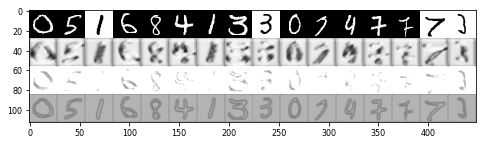

In [79]:
plt.imshow(((np.squeeze(image_mnists) + 1) * 127.5).astype(np.uint8), cmap='gray')
plt.show()